# Step 1: Import Libraries


Import all necessary libraries for data processing, modeling, and evaluation.

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
import shap
from geopy.distance import geodesic
import warnings
warnings.filterwarnings("ignore")


# Step 2: Load the Dataset

Load the training and testing datasets and print their shapes to verify the data

In [4]:
# Load the training and testing datasets
train_data = pd.read_csv('/kaggle/input/credit-card-fraud-detection/fraudTrain.csv')
test_data = pd.read_csv('/kaggle/input/credit-card-fraud-detection/fraudTest.csv')

# Print shapes of train and test data
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (1296675, 23)
Test data shape: (555719, 23)


# Step 3: Handle Missing Values

Impute missing values in numerical columns to prevent data loss

In [5]:
# Impute missing values instead of dropping rows to prevent data loss
from sklearn.impute import SimpleImputer

# Impute numerical columns with the mean
numerical_cols = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']
imputer = SimpleImputer(strategy='mean')
train_data[numerical_cols] = imputer.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = imputer.transform(test_data[numerical_cols])

# Print shapes after handling missing values
print(f"Train data shape after imputation: {train_data.shape}")
print(f"Test data shape after imputation: {test_data.shape}")


Train data shape after imputation: (1296675, 23)
Test data shape after imputation: (555719, 23)


# Step 4: Feature Engineering
Create new features (e.g., temporal, behavioral, geolocation) and preprocess the data

In [6]:
# Create new features to capture temporal, behavioral, and geolocation patterns
def preprocess_data(data):
    # Convert timestamp and extract temporal features
    data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
    data['hour'] = data['trans_date_trans_time'].dt.hour
    data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek
    data['day_of_month'] = data['trans_date_trans_time'].dt.day
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    data['season'] = data['trans_date_trans_time'].dt.month % 12 // 3 + 1

    # Calculate distance between customer and merchant
    data['distance'] = data.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)

    # Drop unnecessary columns
    data.drop(columns=['trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time', 'merchant'], inplace=True)

    # One-hot encode categorical variables
    data = pd.get_dummies(data, columns=['category', 'gender'], drop_first=True)

    # Scale transaction amount
    scaler = StandardScaler()
    data['amt'] = scaler.fit_transform(data[['amt']])
    return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Print shapes after preprocessing
print(f"Train data shape after preprocessing: {train_data.shape}")
print(f"Test data shape after preprocessing: {test_data.shape}")

Train data shape after preprocessing: (1296675, 29)
Test data shape after preprocessing: (555719, 29)


# Step 5: Split the Data

In [7]:
# Separate features and target variable
X_train = train_data.drop(columns=['is_fraud'])
y_train = train_data['is_fraud']
X_test = test_data.drop(columns=['is_fraud'])
y_test = test_data['is_fraud']

# Print shapes after splitting
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1296675, 28)
y_train shape: (1296675,)
X_test shape: (555719, 28)
y_test shape: (555719,)


# Step 6: Handle Class Imbalance
Use SMOTE to balance the dataset by oversampling the minority class.

In [8]:
# Use SMOTE to balance the dataset by oversampling the minority class
from imblearn.over_sampling import SMOTE

# Check class imbalance before applying SMOTE
print("Class distribution before oversampling:")
print(y_train.value_counts())

Class distribution before oversampling:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [9]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print shapes after SMOTE
print(f"X_resampled shape: {X_resampled.shape}")
print(f"y_resampled shape: {y_resampled.shape}")

X_resampled shape: (2578338, 28)
y_resampled shape: (2578338,)


# Step 7: Build the Model
Define a deep learning model with LSTM layers and regularization techniques.

In [10]:
# Define a deep learning model with LSTM layers for sequential data and regularization to avoid overfitting
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_resampled.shape[1], 1)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Nadam optimizer and binary cross-entropy loss
model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the Model
Train the model with early stopping, learning rate scheduling, and class weights

In [11]:
# Use EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Reduced patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model with adjusted class weights
class_weight = {0: 1, 1: 20}  # Increased weight for the minority class
history = model.fit(X_resampled, y_resampled, epochs=50, batch_size=256, validation_split=0.2, callbacks=[early_stopping, reduce_lr, checkpoint], class_weight=class_weight)

Epoch 1/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 125s 15ms/step - accuracy: 0.8353 - loss: 0.7098 - val_accuracy: 0.9942 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 2/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - accuracy: 0.9348 - loss: 0.3233 - val_accuracy: 0.9898 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 3/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - accuracy: 0.9476 - loss: 0.2626 - val_accuracy: 0.9940 - val_loss: 0.0140 - learning_rate: 0.0010
Epoch 4/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - accuracy: 0.9519 - loss: 0.2333 - val_accuracy: 0.9973 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 5/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - accuracy: 0.9534 - loss: 0.2150 - val_accuracy: 0.9967 - val_loss: 0.0088 - learning_rate: 0.0010
Epoch 6/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step - accuracy: 0.9579 - loss: 0.1983 - val_accuracy: 0.9969 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/50
8058/8058 ━━━━━━━━━━━━━━━━━━━━ 122s 15ms/step -

# Step 9: Evaluate the Model

In [12]:
# Evaluate the model on the test set using advanced metrics
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

17367/17367 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    553574
           1       0.04      0.98      0.07      2145

    accuracy                           0.91    555719
   macro avg       0.52      0.94      0.51    555719
weighted avg       1.00      0.91      0.95    555719

Confusion Matrix:
[[501422  52152]
 [    50   2095]]


In [13]:
# Calculate AUC-ROC and F1-score
auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.9412401748963799


In [14]:
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1}")

F1-score: 0.07430131933607603


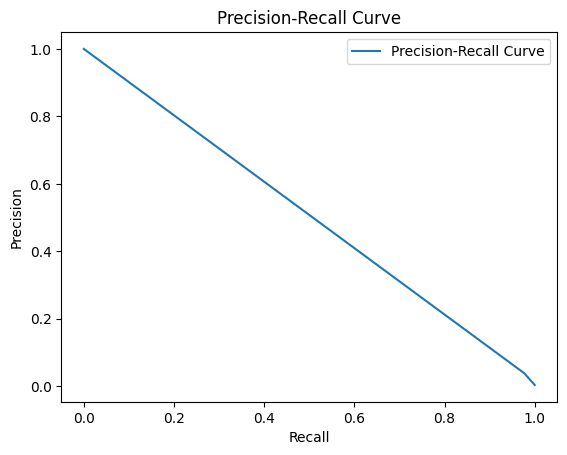

In [15]:
# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()